# Australia & Chile COVID‑19 Weekly Data (Cases/Deaths) with Visualizations
This notebook:
1) Builds **Australia** weekly cases/deaths (Jan 1, 2021 → Dec 31, 2023) from OWID *daily* data and visualizes them.
2) Builds **Chile** weekly cases/deaths split into **pre‑vaccine** (before 2021‑02‑01) and **post‑vaccine** (on/after 2021‑02‑01), and visualizes them.

**Notes**
- Requires internet to download the OWID CSVs at runtime.
- Uses **matplotlib** only, one chart per figure, and does **not** set custom colors.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# ---- Config ----
WEEK_FREQ = "W-SUN"  # weeks ending on Sunday

# Australia window
AUS_COUNTRY = "Australia"
AUS_START   = pd.Timestamp("2021-01-01")
AUS_END     = pd.Timestamp("2023-12-31")

# Chile split
CHL_COUNTRY = "Chile"
CHL_VAX_START = pd.Timestamp("2021-02-01")  # approximate vaccination rollout threshold

# Data sources
OWID_DAILY_URL = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"


In [2]:
def build_weekly_from_daily(df_daily, start=None, end=None, week_freq=WEEK_FREQ):
    """
    Given a daily dataframe with columns ['date','new_cases','new_deaths'],
    returns a weekly-summed dataframe with columns:
    ['week_start','week_end','weekly_cases','weekly_deaths']
    covering a complete weekly grid from the first Sunday within the range.
    """
    d = df_daily.copy()
    if start is None:
        start = d['date'].min()
    if end is None:
        end = d['date'].max()
    # buffer to compute first full week
    buffer_start = pd.to_datetime(start) - pd.Timedelta(days=6)
    d = d[(d['date'] >= buffer_start) & (d['date'] <= end)].copy()
    d[['new_cases','new_deaths']] = d[['new_cases','new_deaths']].apply(pd.to_numeric, errors="coerce").fillna(0)

    weekly = (d.set_index('date')
                .resample(week_freq)
                .sum()[['new_cases','new_deaths']])

    # Build complete weekly index from first Sunday after year's start to end
    first_week_end = pd.date_range(pd.Timestamp(start.year,1,1), pd.Timestamp(start.year,1,7), freq='D')
    first_sunday = [dt for dt in first_week_end if dt.weekday() == 6][0]  # weekday==6 is Sunday
    last_sunday  = pd.Timestamp(end.year,12,31)
    while last_sunday.weekday() != 6:
        last_sunday -= pd.Timedelta(days=1)

    full_weeks = pd.date_range(first_sunday, last_sunday, freq=week_freq)
    weekly = weekly.reindex(full_weeks, fill_value=0)
    weekly.index.name = "week_end"
    weekly = weekly.rename(columns={"new_cases":"weekly_cases","new_deaths":"weekly_deaths"})
    weekly["week_start"] = weekly.index - pd.to_timedelta(6, unit="D")
    weekly = weekly.reset_index()[["week_start","week_end","weekly_cases","weekly_deaths"]]
    return weekly


## Australia: Weekly Cases & Deaths (2021–2023)

    week_start   week_end  weekly_cases  weekly_deaths
0   2020-12-28 2021-01-03         187.0            2.0
1   2021-01-04 2021-01-10         112.0            0.0
2   2021-01-11 2021-01-17         113.0            1.0
3   2021-01-18 2021-01-24          58.0            0.0
4   2021-01-25 2021-01-31          45.0            0.0
5   2021-02-01 2021-02-07          39.0            0.0
6   2021-02-08 2021-02-14          48.0            0.0
7   2021-02-15 2021-02-21          28.0            1.0
8   2021-02-22 2021-02-28          44.0            0.0
9   2021-03-01 2021-03-07          67.0            0.0
10  2021-03-08 2021-03-14          80.0            1.0
11  2021-03-15 2021-03-21          79.0            0.0
12  2021-03-22 2021-03-28          64.0            0.0
13  2021-03-29 2021-04-04          88.0            1.0
14  2021-04-05 2021-04-11          57.0            0.0
15  2021-04-12 2021-04-18         114.0            2.0
16  2021-04-19 2021-04-25         147.0            0.0
17  2021-0

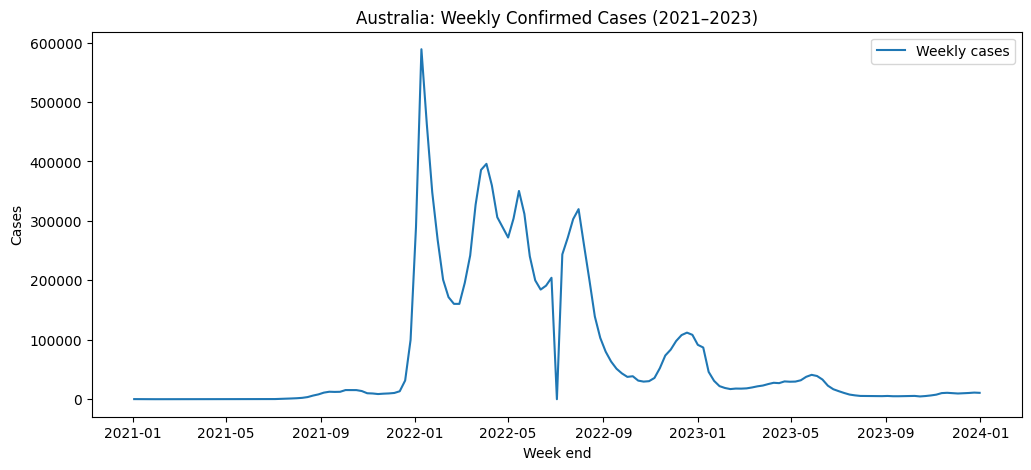

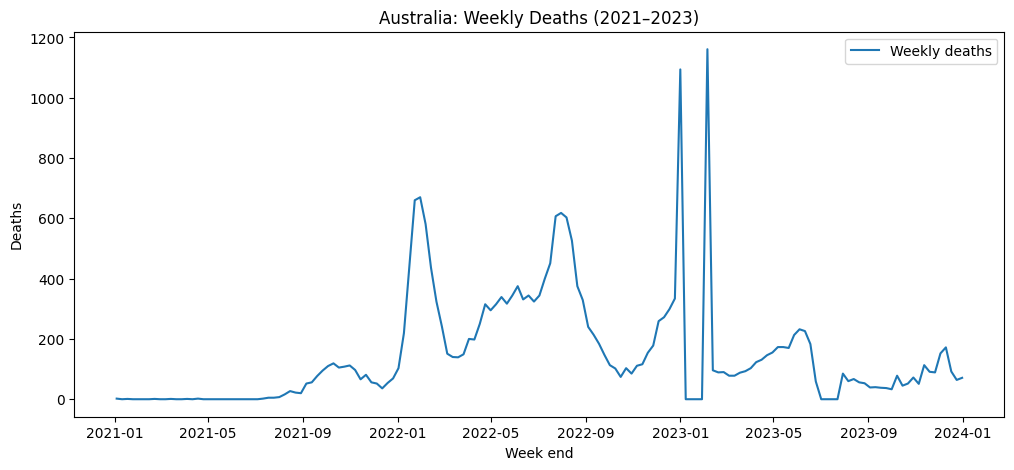

In [3]:
# Load OWID daily for Australia
cols = ["location","date","new_cases","new_deaths"]
daily_all = pd.read_csv(OWID_DAILY_URL, usecols=cols, parse_dates=["date"])
daily_aus = daily_all.query("location == @AUS_COUNTRY and @AUS_START <= date <= @AUS_END").copy()

# Build weekly table
aus_weekly = build_weekly_from_daily(daily_aus, start=AUS_START, end=AUS_END)

# Save
aus_out_csv = "Australia_COVID_Weekly_2021_2023.csv"
aus_weekly.to_csv(aus_out_csv, index=False)

# Show full table
pd.set_option("display.max_rows", None)
print(aus_weekly)
print("\nSaved ->", aus_out_csv)

# Visualize: weekly cases
plt.figure(figsize=(12,5))
plt.plot(aus_weekly["week_end"], aus_weekly["weekly_cases"], label="Weekly cases")
plt.title("Australia: Weekly Confirmed Cases (2021–2023)")
plt.xlabel("Week end")
plt.ylabel("Cases")
plt.legend()
plt.show()

# Visualize: weekly deaths
plt.figure(figsize=(12,5))
plt.plot(aus_weekly["week_end"], aus_weekly["weekly_deaths"], label="Weekly deaths")
plt.title("Australia: Weekly Deaths (2021–2023)")
plt.xlabel("Week end")
plt.ylabel("Deaths")
plt.legend()
plt.show()


## Chile: Weekly Cases & Deaths — Pre vs Post Vaccination

  week_start   week_end  weekly_cases  weekly_deaths       period
0 2019-12-30 2020-01-05           0.0            0.0  pre_vaccine
1 2020-01-06 2020-01-12           0.0            0.0  pre_vaccine
2 2020-01-13 2020-01-19           0.0            0.0  pre_vaccine
3 2020-01-20 2020-01-26           0.0            0.0  pre_vaccine
4 2020-01-27 2020-02-02           0.0            0.0  pre_vaccine
...
    week_start   week_end  weekly_cases  weekly_deaths        period
308 2024-11-25 2024-12-01           0.0            0.0  post_vaccine
309 2024-12-02 2024-12-08           0.0            0.0  post_vaccine
310 2024-12-09 2024-12-15           0.0            0.0  post_vaccine
311 2024-12-16 2024-12-22           0.0            0.0  post_vaccine
312 2024-12-23 2024-12-29           0.0            0.0  post_vaccine

Saved -> Chile_COVID_Weekly_pre_post.csv


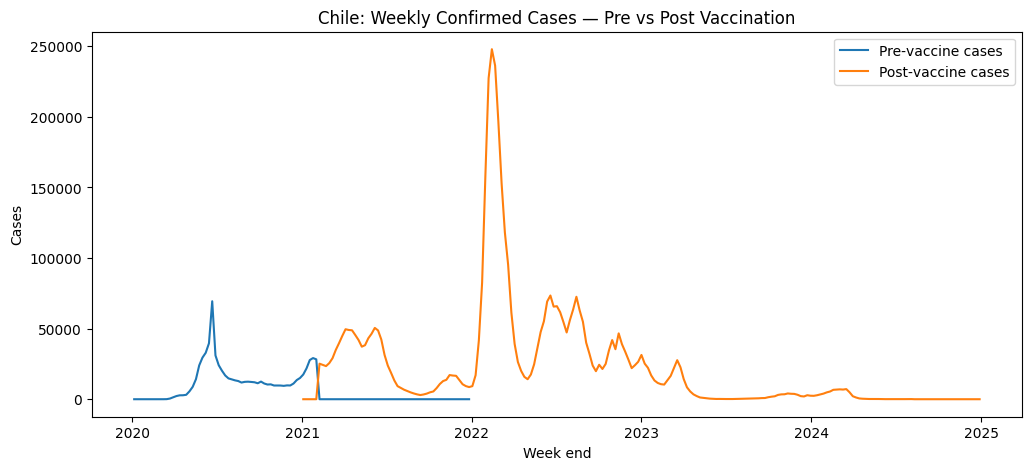

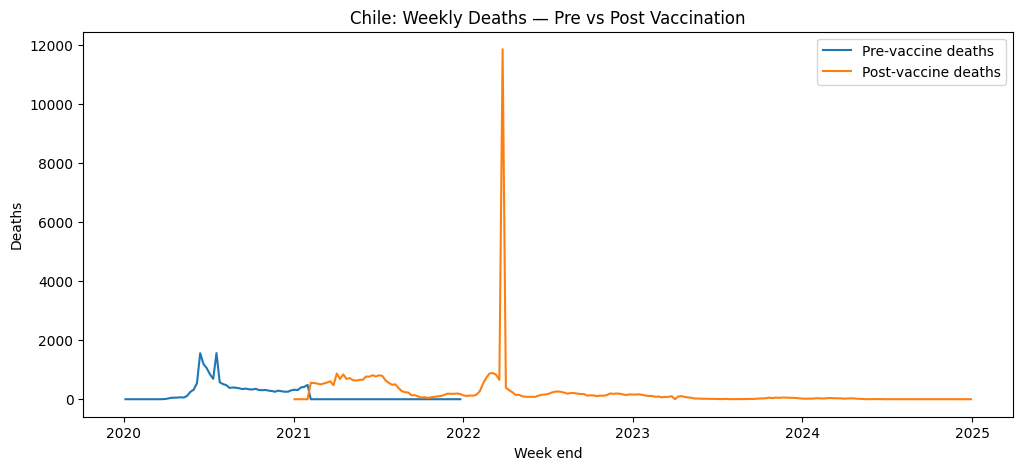

In [8]:
# Load OWID daily for Chile (full range available)
cols = ["location","date","new_cases","new_deaths"]
daily_all = pd.read_csv(OWID_DAILY_URL, usecols=cols, parse_dates=["date"])
daily_chl = daily_all.query("location == @CHL_COUNTRY").copy()

# Split into pre- and post-vaccine
chl_pre  = daily_chl[daily_chl["date"] < CHL_VAX_START].copy()
chl_post = daily_chl[daily_chl["date"] >= CHL_VAX_START].copy()

# Weekly
chl_pre_w  = build_weekly_from_daily(chl_pre,  start=chl_pre["date"].min(),  end=chl_pre["date"].max())
chl_post_w = build_weekly_from_daily(chl_post, start=chl_post["date"].min(), end=chl_post["date"].max())

# Add period labels and combine
chl_pre_w["period"]  = "pre_vaccine"
chl_post_w["period"] = "post_vaccine"
chl_weekly = pd.concat([chl_pre_w, chl_post_w], ignore_index=True)

# Save
chl_out_csv = "Chile_COVID_Weekly_pre_post.csv"
chl_weekly.to_csv(chl_out_csv, index=False)

# Show brief
print(chl_weekly.head())
print("...")
print(chl_weekly.tail())
print("\nSaved ->", chl_out_csv)

# Visualize cases: pre vs post (two lines in one figure)
plt.figure(figsize=(12,5))
pre_mask  = (chl_weekly["period"] == "pre_vaccine")
post_mask = (chl_weekly["period"] == "post_vaccine")
plt.plot(chl_weekly.loc[pre_mask, "week_end"],  chl_weekly.loc[pre_mask, "weekly_cases"],  label="Pre‑vaccine cases")
plt.plot(chl_weekly.loc[post_mask, "week_end"], chl_weekly.loc[post_mask, "weekly_cases"], label="Post‑vaccine cases")
plt.title("Chile: Weekly Confirmed Cases — Pre vs Post Vaccination")
plt.xlabel("Week end")
plt.ylabel("Cases")
plt.legend()
plt.show()

# Visualize deaths: pre vs post
plt.figure(figsize=(12,5))
plt.plot(chl_weekly.loc[pre_mask, "week_end"],  chl_weekly.loc[pre_mask, "weekly_deaths"],  label="Pre‑vaccine deaths")
plt.plot(chl_weekly.loc[post_mask, "week_end"], chl_weekly.loc[post_mask, "weekly_deaths"], label="Post‑vaccine deaths")
plt.title("Chile: Weekly Deaths — Pre vs Post Vaccination")
plt.xlabel("Week end")
plt.ylabel("Deaths")
plt.legend()
plt.show()


### Display All Chile Weekly Values
Now we print the entire weekly dataset for Chile (pre- and post-vaccine combined), similar to how we displayed the full table for Australia.

In [5]:
pd.set_option("display.max_rows", None)
print(chl_weekly)
print("\nRows:", len(chl_weekly))
print("Totals: Cases =", chl_weekly["weekly_cases"].sum(),
      ", Deaths =", chl_weekly["weekly_deaths"].sum())

    week_start   week_end  weekly_cases  weekly_deaths        period
0   2019-12-30 2020-01-05           0.0            0.0   pre_vaccine
1   2020-01-06 2020-01-12           0.0            0.0   pre_vaccine
2   2020-01-13 2020-01-19           0.0            0.0   pre_vaccine
3   2020-01-20 2020-01-26           0.0            0.0   pre_vaccine
4   2020-01-27 2020-02-02           0.0            0.0   pre_vaccine
5   2020-02-03 2020-02-09           0.0            0.0   pre_vaccine
6   2020-02-10 2020-02-16           0.0            0.0   pre_vaccine
7   2020-02-17 2020-02-23           0.0            0.0   pre_vaccine
8   2020-02-24 2020-03-01           1.0            0.0   pre_vaccine
9   2020-03-02 2020-03-08           6.0            0.0   pre_vaccine
10  2020-03-09 2020-03-15          54.0            0.0   pre_vaccine
11  2020-03-16 2020-03-22         476.0            0.0   pre_vaccine
12  2020-03-23 2020-03-29        1372.0            6.0   pre_vaccine
13  2020-03-30 2020-04-05        2